In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import sklearn.preprocessing
import umap
import time
import random
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import pickle
from sklearn.model_selection import KFold
import math


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if not torch.cuda.is_available():
    raise Exception('Code will not work without a GPU!')

uhd_data = pd.DataFrame(np.genfromtxt("wf_data.csv", delimiter=',', dtype=None, encoding='utf-8'))
uhd_data = sklearn.preprocessing.normalize(uhd_data, norm='l2')

uhd_acg = pd.DataFrame(np.genfromtxt("acg_data.csv", delimiter=',', dtype=None, encoding='utf-8'))
uhd_acg = sklearn.preprocessing.normalize(uhd_acg, norm='l2')

uhd_labels = pd.DataFrame(np.genfromtxt("label_data.csv", delimiter=',', dtype=None, encoding='utf-8'))
uhd_labels = uhd_labels.rename(columns={0:'cell_type'})
uhd_labels.loc[uhd_labels['cell_type'].isin(['RS','FSs','FSl']), 'cell_type'] = 'untagged'

/usr3/graduate/kenjilee/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/share/pkg.7/python3/3.8.3/install/lib/python3.8/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [2]:
acg = uhd_acg.reshape(-1, 10, 101)
wf = uhd_data.reshape(-1, 1, uhd_data.shape[1])
labels = uhd_labels['cell_type'].tolist()

In [3]:
def encode_labels(labels):
    label_mapping = {'PV': 0, 'SST': 1, 'VIP': 2, 'untagged': 3}
    encoded_labels = [label_mapping[label] for label in labels]
    return encoded_labels

# Example usage
encoded_labels = encode_labels(labels)

In [4]:
class WaveformVAE_NEMO(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=10):
        super(WaveformVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calculate flattened size
        self.flatten_size = hidden_dim * (input_dim // 1)
        
        # Latent space
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, self.flatten_size)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, -1)),
            nn.ConvTranspose1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 1, kernel_size=3, padding=1)
        )
        
        # Move model to GPU
        self.to(device)
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std).to(device)
        return mu + eps * std
    
    def decode(self, z):
        x = self.decoder_input(z)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

class ACGVAE_NEMO(nn.Module):
    def __init__(self, input_channels=10, sequence_length=101, hidden_dim=64, latent_dim=10):
        super(ACGVAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calculate flattened size
        self.flatten_size = 64 * sequence_length
        
        # Latent space
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, self.flatten_size)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, sequence_length)),
            nn.ConvTranspose1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, input_channels, kernel_size=3, padding=1)
        )
        
        # Move model to GPU
        self.to(device)
    
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std).to(device)
        return mu + eps * std
    
    def decode(self, z):
        x = self.decoder_input(z)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

In [5]:
class WaveformVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=10):
        super(WaveformVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calculate flattened size
        self.flatten_size = hidden_dim * (input_dim // 1)
        
        # Latent space
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, self.flatten_size)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, -1)),
            nn.ConvTranspose1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 1, kernel_size=3, padding=1)
        )
        
        # Move model to GPU
        self.to(device)
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std).to(device)
        return mu + eps * std
    
    def decode(self, z):
        x = self.decoder_input(z)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

class ACGVAE(nn.Module):
    def __init__(self, input_channels=10, sequence_length=101, hidden_dim=64, latent_dim=10):
        super(ACGVAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calculate flattened size
        self.flatten_size = 64 * sequence_length
        
        # Latent space
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, self.flatten_size)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, sequence_length)),
            nn.ConvTranspose1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, input_channels, kernel_size=3, padding=1)
        )
        
        # Move model to GPU
        self.to(device)
    
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std).to(device)
        return mu + eps * std
    
    def decode(self, z):
        x = self.decoder_input(z)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def vae_loss(recon_x, x, mu, log_var, kl_weight=1., recon_weight=1., beta=1.0):
    """
    VAE loss function with weighted KL divergence
    """
    # Reconstruction loss (MSE per dimension to balance with KL)
    recon_loss = F.mse_loss(recon_x, x, reduction='mean') * x.numel()
    
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    # Check if the latent space is being used
    latent_activity = torch.mean(torch.abs(mu))
    
    return recon_loss * recon_weight + kl_weight * kl_loss * beta, recon_loss, kl_loss, latent_activity

def train_vaes(wf_vae, acg_vae, wf_data, acg_data, epochs=100, batch_size=64, learning_rate=1e-3, 
               warmup_epochs=10, max_wf_beta=1, max_acg_beta=1, beta_start=1e-6, 
               annealing_type='logistic', steepness=8, plot_training=False):
    """
    Train both VAEs simultaneously with a smooth annealing schedule for beta.
    
    Args:
        warmup_epochs: Number of initial epochs for deterministic warm-up (KL weight = 0)
        max_wf_beta: Maximum beta value for waveform VAE
        max_acg_beta: Maximum beta value for ACG VAE
        beta_start: Initial beta value after warmup
        annealing_type: Type of annealing schedule ('linear', 'logistic', or 'exponential')
    """
    # Convert numpy arrays to PyTorch tensors (keep on CPU initially)
    wf_tensor = torch.FloatTensor(wf_data)
    acg_tensor = torch.FloatTensor(acg_data)
    
    # Create dataset and dataloader
    dataset = TensorDataset(wf_tensor, acg_tensor)
    # Only use pin_memory if we're using CUDA
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, 
                          pin_memory=True if torch.cuda.is_available() else False)
    
    # Optimizers
    wf_optimizer = torch.optim.Adam(wf_vae.parameters(), lr=learning_rate)
    acg_optimizer = torch.optim.Adam(acg_vae.parameters(), lr=learning_rate)
    
    # Lists to store losses
    wf_losses = {'total': [], 'recon': [], 'kl': []}
    acg_losses = {'total': [], 'recon': [], 'kl': []}
    kl_weights = []  # For tracking KL weight values
    wf_beta_values = []  # For tracking WF beta values
    acg_beta_values = []  # For tracking ACG beta values
    
    # Enable cuDNN benchmarking for better performance
    torch.backends.cudnn.benchmark = True
    
    # Training loop with annealing schedules
    for epoch in range(epochs):
        # Compute KL weight:
        # 1. First warmup_epochs: KL weight = 0 (deterministic warm-up)
        # 2. After warm-up: gradually increase from 0 to 1
        if epoch < warmup_epochs:
            # Deterministic warm-up (KL weight = 0)
            kl_weight = 0.0
            wf_beta = 0.0
            acg_beta = 0.0
        else:
            # KL weight ramps up to 1.0 linearly over the remaining epochs
            progress = (epoch - warmup_epochs) / (epochs - warmup_epochs)
            kl_weight = min(1.0, progress)
            
            # Beta annealing schedules (starts from beta_start after warmup)
            if annealing_type == 'linear':
                # Linear annealing from beta_start to max_beta
                wf_beta = beta_start + progress * (max_wf_beta - beta_start)
                acg_beta = beta_start + progress * (max_acg_beta - beta_start)
            
            elif annealing_type == 'exponential':
                # Exponential annealing from beta_start to max_beta
                wf_beta = beta_start * (max_wf_beta / beta_start) ** progress
                acg_beta = beta_start * (max_acg_beta / beta_start) ** progress
            
            elif annealing_type == 'logistic':
                # Logistic annealing (smooth S-curve)
                # Center the logistic curve at the middle of training
                mid_point = 0.5
                # Steepness of the curve (higher = steeper transition)
                steepness = steepness
                
                # Compute logistic function: 1 / (1 + exp(-steepness * (progress - mid_point)))
                # This gives a smooth S-curve from 0 to 1
                logistic_value = 1 / (1 + math.exp(-steepness * (progress - mid_point)))
                
                # Scale the logistic curve from beta_start to max_beta
                wf_beta = beta_start + logistic_value * (max_wf_beta - beta_start)
                acg_beta = beta_start + logistic_value * (max_acg_beta - beta_start)
            
            else:
                raise ValueError(f"Unknown annealing type: {annealing_type}")
        
        kl_weights.append(kl_weight)
        wf_beta_values.append(wf_beta)
        acg_beta_values.append(acg_beta)
        
        epoch_wf_loss = {'total': 0, 'recon': 0, 'kl': 0}
        epoch_acg_loss = {'total': 0, 'recon': 0, 'kl': 0}
        
        for batch_wf, batch_acg in dataloader:
            # Move batch data to GPU
            batch_wf = batch_wf.to(device)
            batch_acg = batch_acg.to(device)
            
            # Train Waveform VAE
            wf_optimizer.zero_grad()
            wf_recon, wf_mu, wf_log_var = wf_vae(batch_wf)
            wf_total_loss, wf_recon_loss, wf_kl_loss, wf_latent_activity = vae_loss(
                wf_recon, batch_wf, wf_mu, wf_log_var, kl_weight, recon_weight=1.0, beta=wf_beta
            )
            wf_total_loss.backward()
            wf_optimizer.step()
            
            # Train ACG VAE
            acg_optimizer.zero_grad()
            acg_recon, acg_mu, acg_log_var = acg_vae(batch_acg)
            acg_total_loss, acg_recon_loss, acg_kl_loss, acg_latent_activity = vae_loss(
                acg_recon, batch_acg, acg_mu, acg_log_var, kl_weight, recon_weight=1.0, beta=acg_beta
            )
            acg_total_loss.backward()
            acg_optimizer.step()
            
            # Accumulate losses (detach from GPU for CPU numpy operations)
            epoch_wf_loss['total'] += wf_total_loss.item()
            epoch_wf_loss['recon'] += wf_recon_loss.item()
            epoch_wf_loss['kl'] += wf_kl_loss.item()
            
            epoch_acg_loss['total'] += acg_total_loss.item()
            epoch_acg_loss['recon'] += acg_recon_loss.item()
            epoch_acg_loss['kl'] += acg_kl_loss.item()
        
        # Average losses over batches
        for key in epoch_wf_loss:
            epoch_wf_loss[key] /= len(dataloader)
            epoch_acg_loss[key] /= len(dataloader)
            wf_losses[key].append(epoch_wf_loss[key])
            acg_losses[key].append(epoch_acg_loss[key])
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{epochs}], KL weight: {kl_weight:.4f}, '
                  f'WF Beta: {wf_beta:.6f}, ACG Beta: {acg_beta:.6f}')
            print(f'Waveform VAE - Total: {epoch_wf_loss["total"]:.4f}, '
                  f'Recon: {epoch_wf_loss["recon"]:.4f}, KL: {epoch_wf_loss["kl"]:.4f}')
            print(f'ACG VAE - Total: {epoch_acg_loss["total"]:.4f}, '
                  f'Recon: {epoch_acg_loss["recon"]:.4f}, KL: {epoch_acg_loss["kl"]:.4f}')
    
    if plot_training:
        # Plot training curves and KL weight schedule
        fig = plot_training_curves(wf_losses, acg_losses, kl_weights, wf_beta_values, acg_beta_values)
        plt.show()
            
    return wf_vae, acg_vae, wf_losses, acg_losses

def plot_training_curves(wf_losses, acg_losses, kl_weights=None, wf_beta_values=None, acg_beta_values=None):
    """
    Plot training curves for both VAEs and optionally the KL weight and beta schedules
    """
    num_plots = 2  # At minimum, we have 2 plots (one for each VAE's losses)
    if kl_weights is not None:
        num_plots += 1
    if wf_beta_values is not None and acg_beta_values is not None:
        num_plots += 1
    
    fig, axes = plt.subplots(num_plots, 1, figsize=(12, 5 * num_plots))
    
    # Plot Waveform VAE losses
    axes[0].plot(wf_losses['total'], label='Total Loss')
    axes[0].plot(wf_losses['recon'], label='Reconstruction Loss')
    axes[0].plot(wf_losses['kl'], label='KL Divergence')
    axes[0].set_title('Waveform VAE Training Losses')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_yscale('log')
    
    # Plot ACG VAE losses
    axes[1].plot(acg_losses['total'], label='Total Loss')
    axes[1].plot(acg_losses['recon'], label='Reconstruction Loss')
    axes[1].plot(acg_losses['kl'], label='KL Divergence')
    axes[1].set_title('ACG VAE Training Losses')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_yscale('log')
    
    plot_idx = 2
    
    # Plot KL weight schedule if provided
    if kl_weights is not None:
        axes[plot_idx].plot(kl_weights, 'r-', label='KL Weight')
        axes[plot_idx].set_title('KL Annealing Schedule')
        axes[plot_idx].set_xlabel('Epochs')
        axes[plot_idx].set_ylabel('KL Weight')
        axes[plot_idx].legend()
        axes[plot_idx].grid(True)
        plot_idx += 1
    
    # Plot beta schedules if provided
    if wf_beta_values is not None and acg_beta_values is not None:
        axes[plot_idx].plot(wf_beta_values, 'b-', label='WF Beta')
        axes[plot_idx].plot(acg_beta_values, 'g-', label='ACG Beta')
        axes[plot_idx].set_title('Beta Annealing Schedules')
        axes[plot_idx].set_xlabel('Epochs')
        axes[plot_idx].set_ylabel('Beta Value')
        axes[plot_idx].legend()
        axes[plot_idx].grid(True)
    
    plt.tight_layout()
    return fig

Epoch [1/200], KL weight: 0.0000, WF Beta: 0.024938, ACG Beta: 0.024938
Waveform VAE - Total: 564.7325, Recon: 564.7325, KL: 6322.0003
ACG VAE - Total: 2704.0533, Recon: 2704.0533, KL: 2751.3385
Epoch [10/200], KL weight: 0.0450, WF Beta: 0.024944, ACG Beta: 0.024944
Waveform VAE - Total: 19.7968, Recon: 3.7968, KL: 14254.4162
ACG VAE - Total: 51.6500, Recon: 35.3893, KL: 14486.6591
Epoch [20/200], KL weight: 0.0950, WF Beta: 0.024950, ACG Beta: 0.024950
Waveform VAE - Total: 26.7187, Recon: 6.0045, KL: 8739.2909
ACG VAE - Total: 51.6373, Recon: 26.2123, KL: 10726.7328
Epoch [30/200], KL weight: 0.1450, WF Beta: 0.024956, ACG Beta: 0.024956
Waveform VAE - Total: 17.4128, Recon: 3.9950, KL: 3707.9717
ACG VAE - Total: 42.6530, Recon: 25.9292, KL: 4621.5812
Epoch [40/200], KL weight: 0.1950, WF Beta: 0.024962, ACG Beta: 0.024962
Waveform VAE - Total: 14.6250, Recon: 3.7055, KL: 2243.2605
ACG VAE - Total: 30.3897, Recon: 21.8427, KL: 1755.8590
Epoch [50/200], KL weight: 0.2450, WF Beta: 0.

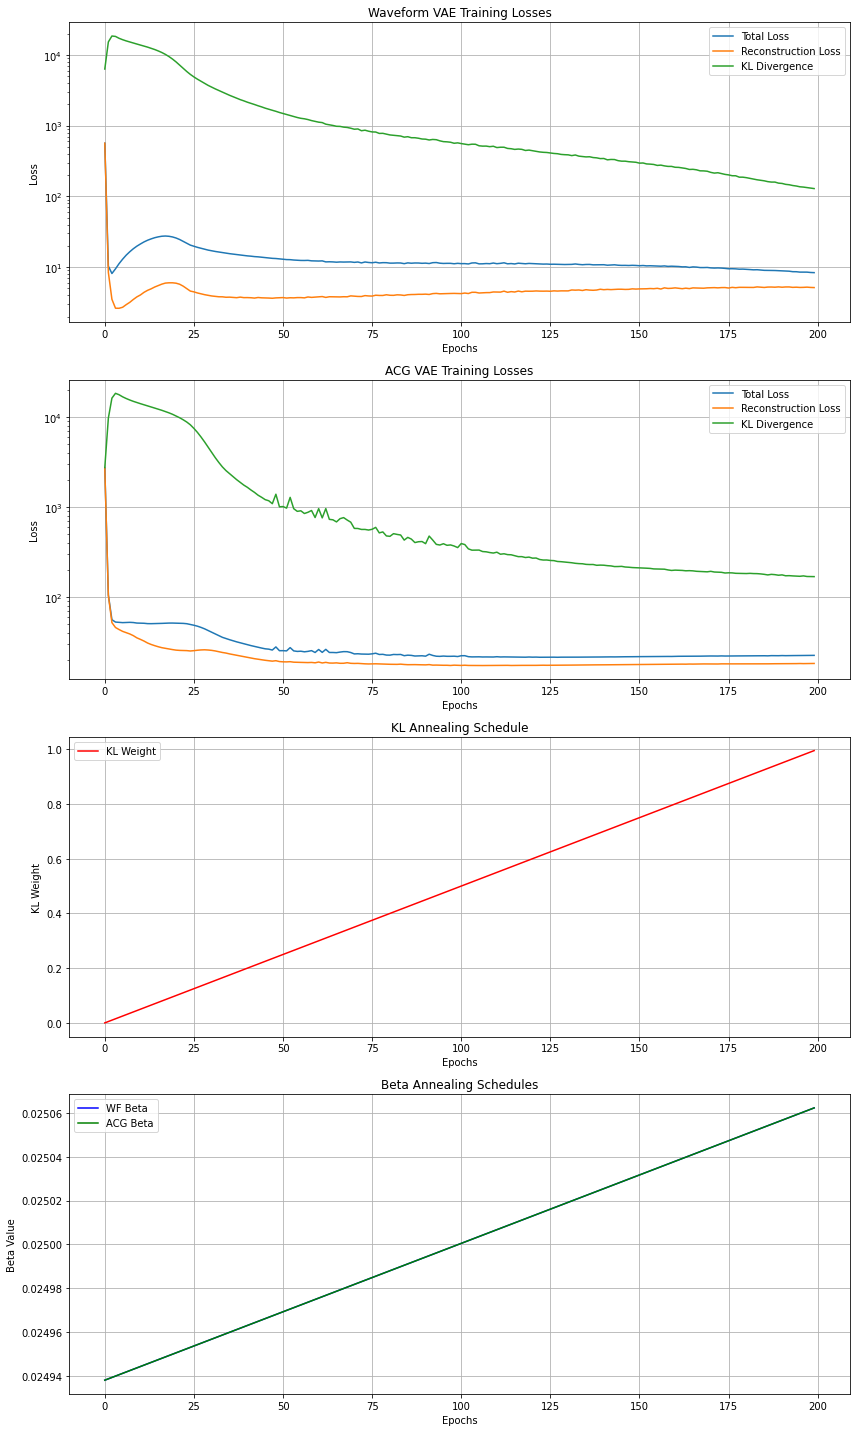

88.4648003578186


In [6]:
# Initialize VAEs with smaller latent dimension to start
wf_vae = WaveformVAE(input_dim=wf.shape[2], latent_dim=81)  # Match latent dim to Herzfeld, Hall, and Lisberger
acg_vae = ACGVAE(latent_dim=81)  # Match latent dim to Herzfeld, Hall, and Lisberger

start_time = time.time()
# Train with KL annealing
wf_vae, acg_vae, wf_losses, acg_losses = train_vaes(
    wf_vae, 
    acg_vae, 
    wf, 
    acg,
    epochs = 200, # (100)
    learning_rate=1e-4,  # Reduced learning rate (1e-3)
    max_wf_beta = 0.05, # Reduced beta to emphasize reconstruction (0.01)
    max_acg_beta = 0.05,
    plot_training = True,
    warmup_epochs=0,
    steepness=0.01
)
end_time = time.time()
print(end_time-start_time)

In [7]:
def freeze_model(model):
    """Freeze all parameters of the model"""
    for param in model.parameters():
        param.requires_grad = False
    model.eval()
    return model

def reconstruct_samples(vae, input_data, n_samples=5):
    """
    Reconstruct samples using a frozen VAE
    
    Args:
        vae: Trained VAE model
        input_data: Input data tensor
        n_samples: Number of samples to reconstruct
    Returns:
        Original samples and their reconstructions
    """
    # Ensure model is frozen and in eval mode
    vae = freeze_model(vae)
    
    # Convert to tensor if necessary
    if not isinstance(input_data, torch.Tensor):
        input_data = torch.cuda.FloatTensor(input_data)
    
    # Randomly select samples
    indices = np.random.choice(len(input_data), n_samples, replace=False)
    samples = input_data[indices]
    
    with torch.no_grad():
        # Get reconstructions
        reconstructions, _, _ = vae(samples)
    
    return samples.cpu().numpy(), reconstructions.cpu().numpy()

def plot_waveform_reconstructions(original, reconstructed):
    """Plot waveform reconstructions"""
    n_samples = len(original)
    fig, axes = plt.subplots(n_samples, 1, figsize=(4, 2*n_samples))
    if n_samples == 1:
        axes = [axes]
    
    for i, (orig, recon) in enumerate(zip(original, reconstructed)):
        orig = orig.squeeze()
        recon = recon.squeeze()
        
        axes[i].plot(orig, 'b-', label='Original', alpha=0.6)
        axes[i].plot(recon, 'r--', label='Reconstructed', alpha=0.6)
        axes[i].set_title(f'Sample {i+1}')
        axes[i].legend()
        axes[i].grid(True)
    
    plt.tight_layout()
    return fig

def plot_acg_reconstructions(original, reconstructed):
    """Plot ACG reconstructions"""
    n_samples = len(original)
    fig, axes = plt.subplots(n_samples, 2, figsize=(5, 2*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, 2)
    
    for i, (orig, recon) in enumerate(zip(original, reconstructed)):
        # Plot original
        im1 = axes[i, 0].imshow(orig.squeeze(), aspect='auto', cmap='viridis')
        axes[i, 0].set_title(f'Original ACG {i+1}')
        plt.colorbar(im1, ax=axes[i, 0])
        
        # Plot reconstruction
        im2 = axes[i, 1].imshow(recon.squeeze(), aspect='auto', cmap='viridis')
        axes[i, 1].set_title(f'Reconstructed ACG {i+1}')
        plt.colorbar(im2, ax=axes[i, 1])
    
    plt.tight_layout()
    return

def visualize_reconstructions(vae, data, vae_type='waveform', n_samples=5, save_fig = False):
    """
    Visualize reconstructions from a frozen VAE
    
    Args:
        vae: Trained VAE model
        data: Input data
        vae_type: 'waveform' or 'acg'
        n_samples: Number of samples to visualize
    """
    # Get reconstructions
    original, reconstructed = reconstruct_samples(vae, data, n_samples)
    
    # Plot based on VAE type
    if vae_type.lower() == 'waveform':
        fig = plot_waveform_reconstructions(original, reconstructed)
    else:  # ACG
        fig = plot_acg_reconstructions(original, reconstructed)
    
    if save_fig:
        file_name = vae_type + '_recon.pdf'
        plt.savefig(file_name)
        
    plt.show()
    return

<ipython-input-7-2261cfd20231>:24: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  input_data = torch.cuda.FloatTensor(input_data)


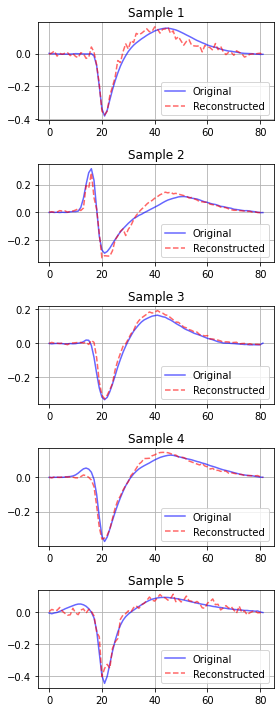

In [8]:
visualize_reconstructions(wf_vae, wf, 'waveform', save_fig=True)

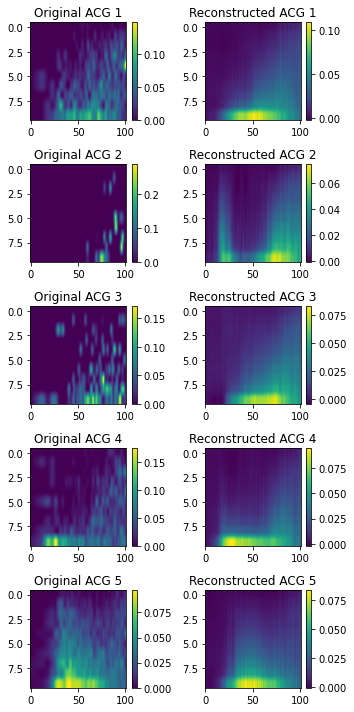

In [9]:
visualize_reconstructions(acg_vae, acg, 'acg', save_fig=True)

In [10]:
def diagnose_encoder(vae, data_tensor, n_samples=1000):
    """
    Diagnose encoder behavior by examining the distribution of means and variances
    """
    vae.eval()
    with torch.no_grad():
        # Get random sample if data is too large
        if len(data_tensor) > n_samples:
            indices = np.random.choice(len(data_tensor), n_samples, replace=False)
            samples = data_tensor[indices]
        else:
            samples = data_tensor
            
        # Get encoder outputs
        mu, log_var = vae.encode(samples)
        
        # Convert to numpy
        mu = mu.cpu().numpy()
        log_var = log_var.cpu().numpy()
        var = np.exp(log_var)
        
        # Create figure
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot distribution of means
        sns.distplot(mu.flatten(), bins=50, ax=ax1)
        ax1.set_title('Distribution of Means (μ)')
        ax1.set_xlabel('μ Value')
        
        # Plot distribution of variances
        sns.distplot(var.flatten(), bins=50, ax=ax2)
        ax2.set_title('Distribution of Variances (σ²)')
        ax2.set_xlabel('σ² Value')
        
        # Plot mean values across latent dimensions
        ax3.boxplot([mu[:, i] for i in range(mu.shape[1])])
        ax3.set_title('Mean Values by Latent Dimension')
        ax3.set_xlabel('Latent Dimension')
        ax3.set_ylabel('μ Value')
        
        # Plot variance values across latent dimensions
        ax4.boxplot([var[:, i] for i in range(var.shape[1])])
        ax4.set_title('Variance Values by Latent Dimension')
        ax4.set_xlabel('Latent Dimension')
        ax4.set_ylabel('σ² Value')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\nEncoder Statistics:")
        print(f"Mean μ: {mu.mean():.4f} ± {mu.std():.4f}")
        print(f"Mean σ²: {var.mean():.4f} ± {var.std():.4f}")
        print(f"μ range: [{mu.min():.4f}, {mu.max():.4f}]")
        print(f"σ² range: [{var.min():.4f}, {var.max():.4f}]")
        
        # Check for constant outputs
        mu_variation = mu.std(axis=0)
        var_variation = var.std(axis=0)
        print("\nVariation across samples:")
        print(f"μ std by dimension: {mu_variation}")
        print(f"σ² std by dimension: {var_variation}")
        
        return mu, var

def test_encoder_response(vae, data_tensor, n_pairs=5):
    """
    Test if encoder responds differently to different inputs
    """
    vae.eval()
    with torch.no_grad():
        # Get random pairs of samples
        indices = np.random.choice(len(data_tensor), 2*n_pairs, replace=False)
        pairs = [(data_tensor[i], data_tensor[i+1]) for i in range(0, len(indices), 2)]
        
        print("\nTesting encoder response to different inputs:")
        for i, (x1, x2) in enumerate(pairs):
            # Get encodings for both inputs
            mu1, log_var1 = vae.encode(x1.unsqueeze(0))
            mu2, log_var2 = vae.encode(x2.unsqueeze(0))
            
            # Compare encodings
            mu_diff = torch.norm(mu1 - mu2).item()
            var_diff = torch.norm(torch.exp(log_var1) - torch.exp(log_var2)).item()
            
            print(f"\nPair {i+1}:")
            print(f"Mean difference (L2): {mu_diff:.4f}")
            print(f"Variance difference (L2): {var_diff:.4f}")

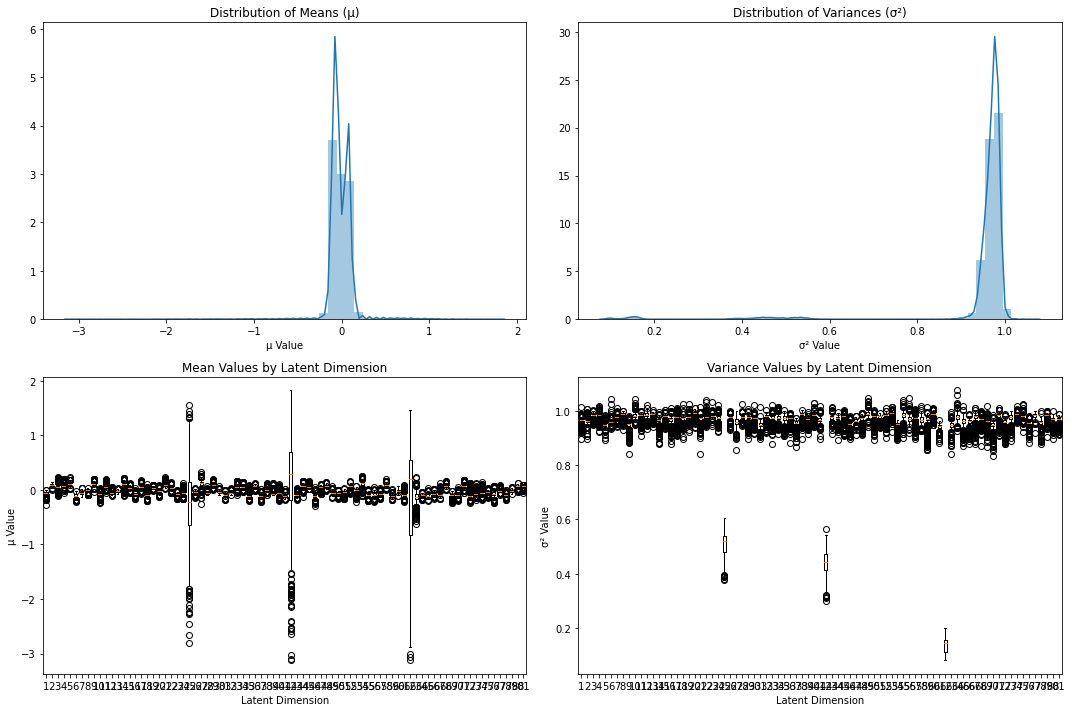


Encoder Statistics:
Mean μ: -0.0186 ± 0.1723
Mean σ²: 0.9491 ± 0.1204
μ range: [-3.1237, 1.8232]
σ² range: [0.0813, 1.0746]

Variation across samples:
μ std by dimension: [0.0256399  0.02125461 0.03903438 0.02364353 0.02899892 0.03124717
 0.02978672 0.01756698 0.02607011 0.02726926 0.02363376 0.01627648
 0.01553432 0.03479114 0.02302994 0.01678278 0.03036265 0.03036468
 0.01108658 0.02426714 0.02628453 0.0262644  0.02291023 0.03083142
 0.6306546  0.02137325 0.05063239 0.0180227  0.02492208 0.02052634
 0.02720704 0.01620569 0.02637379 0.02293162 0.03074769 0.01883981
 0.02826943 0.01951385 0.02218946 0.03269076 0.02450794 0.7257118
 0.02389531 0.02871518 0.01505904 0.03842728 0.02068779 0.0193402
 0.02668725 0.02234208 0.02482683 0.0273491  0.03209062 0.04233155
 0.02936334 0.03197382 0.02218503 0.02209026 0.02478484 0.03231088
 0.03300964 0.93642855 0.08214305 0.01816387 0.0277726  0.02598442
 0.03282025 0.02336773 0.02701166 0.02751111 0.032205   0.03917735
 0.02099688 0.0336241  0.0

In [11]:
mu_wf, var_wf = diagnose_encoder(wf_vae, torch.cuda.FloatTensor(wf))
test_encoder_response(wf_vae, torch.cuda.FloatTensor(wf))

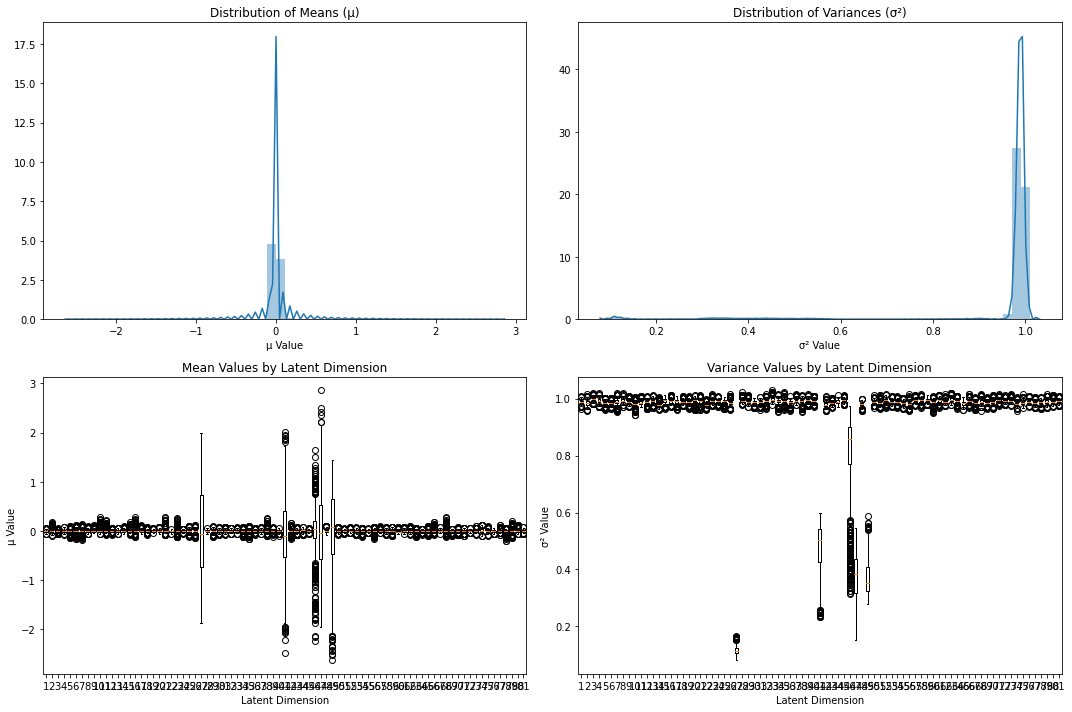


Encoder Statistics:
Mean μ: -0.0000 ± 0.1896
Mean σ²: 0.9543 ± 0.1477
μ range: [-2.6301, 2.8548]
σ² range: [0.0812, 1.0283]

Variation across samples:
μ std by dimension: [0.01969492 0.03370864 0.0137923  0.02723066 0.02837098 0.03295713
 0.03269478 0.02440831 0.01723773 0.03321357 0.02402261 0.01629603
 0.02129073 0.02551822 0.02296404 0.03524984 0.02636431 0.01838846
 0.01602089 0.0217606  0.03168462 0.01759888 0.03244789 0.01421019
 0.03191739 0.03445867 0.9437417  0.02155004 0.02888444 0.02277175
 0.02200732 0.02067886 0.02121882 0.02286871 0.02896198 0.01646676
 0.02060515 0.03199856 0.02037335 0.02166912 0.7226568  0.0338429
 0.02328918 0.02572127 0.01785497 0.4271746  0.7974933  0.03271302
 0.7922968  0.02260049 0.01625938 0.01848811 0.02254067 0.02144751
 0.01439795 0.02649699 0.01572746 0.02313214 0.03018602 0.02217978
 0.02107115 0.02421218 0.02077575 0.01595996 0.02035825 0.02325074
 0.02040181 0.02811021 0.01644547 0.02162597 0.02215026 0.01743002
 0.02044713 0.03993907 0.

In [12]:
mu_acg, var_acg = diagnose_encoder(acg_vae, torch.cuda.FloatTensor(acg))
test_encoder_response(acg_vae, torch.cuda.FloatTensor(acg))

In [13]:
def get_latent_embeddings(vae, data, batch_size=64):
    """
    Get latent embeddings from the beta-VAE for the input data
    
    Args:
        vae: Trained beta-VAE model
        data: Input data tensor
        batch_size: Batch size for processing
    
    Returns:
        numpy array of latent embeddings
    """
    # Ensure model is in eval mode
    vae.eval()
    
    # Convert to tensor if necessary
    if not isinstance(data, torch.Tensor):
        data = torch.FloatTensor(data)
    
    # Create dataloader
    dataset = TensorDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    
    # Get device
    device = next(vae.parameters()).device
    
    # Collect embeddings
    embeddings = []
    with torch.no_grad():
        for batch in dataloader:
            # Move batch to device
            batch = batch[0].to(device)
            
            # Get latent representation (mu)
            mu, _ = vae.encode(batch)
            embeddings.append(mu.cpu().numpy())
    
    # Concatenate all embeddings
    return np.concatenate(embeddings, axis=0)

def visualize_latent_space(vae, data, labels, encoded_labels, 
                          reduction_method='umap', perplexity=30,
                          n_components=2, random_state=42, min_dist = 0.1, n_neighbors=20,
                          savefig = False, filename = ''):
    """
    Visualize the latent space of the beta-VAE using dimensionality reduction
    
    Args:
        vae: Trained beta-VAE model
        data: Input data
        labels: List of label names
        encoded_labels: List of encoded label indices
        reduction_method: 'umap' or 'tsne'
        perplexity: Perplexity parameter for t-SNE (ignored if using UMAP)
        n_components: Number of dimensions to reduce to
        random_state: Random seed for reproducibility
    """
    # Get embeddings
    embeddings = get_latent_embeddings(vae, data)
    
    # Reduce dimensionality
    if reduction_method.lower() == 'umap':
        reducer = umap.UMAP(n_components=n_components, 
                          random_state=random_state, min_dist=min_dist,n_neighbors=n_neighbors)
        embeddings_2d = reducer.fit_transform(embeddings)
    elif reduction_method.lower() == 'tsne':
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=n_components, 
                      perplexity=perplexity,
                      random_state=random_state)
        embeddings_2d = reducer.fit_transform(embeddings)
    else:
        raise ValueError("reduction_method must be 'umap' or 'tsne'")

    # Create visualization
    plt.figure(figsize=(10, 8))
    
    # Color mapping
    colors = ['#D81159', '#00c49a', '#8f15ce', '#ced4da']
    
    # Plot each class
    for i in range(len(labels)):
        mask = np.array(encoded_labels) == i
        plt.scatter(embeddings_2d[mask, 0], 
                   embeddings_2d[mask, 1],
                   c=[colors[i]], 
                   label=labels[i],
                   alpha=0.6,
                   s=3)
    
    plt.title(f'Beta-VAE Latent Space ({reduction_method.upper()})')
    plt.xlabel(f'{reduction_method.upper()} 1')
    plt.ylabel(f'{reduction_method.upper()} 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Print class distribution
    print("\nNumber of points per class:")
    for i, label in enumerate(labels):
        count = sum(np.array(encoded_labels) == i)
        print(f"{label}: {count}")
        
    if savefig:
        file_str = filename+'_UMAP_plot.pdf'
        plt.savefig(file_str)
    
    return embeddings_2d


Number of points per class:
PV: 237
SST: 107
VIP: 118
untagged: 8491

Number of points per class:
PV: 237
SST: 107
VIP: 118
untagged: 8491


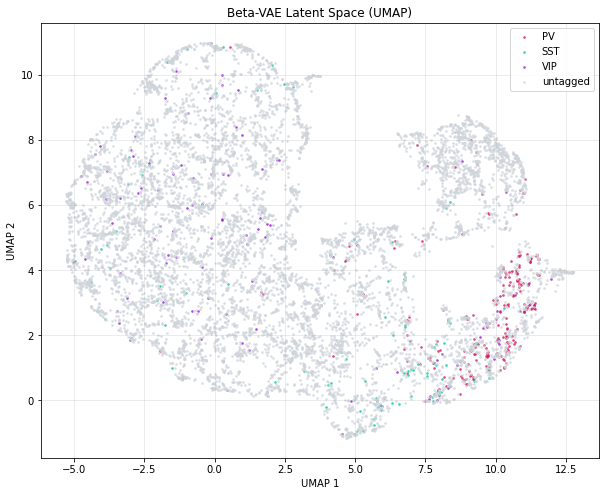

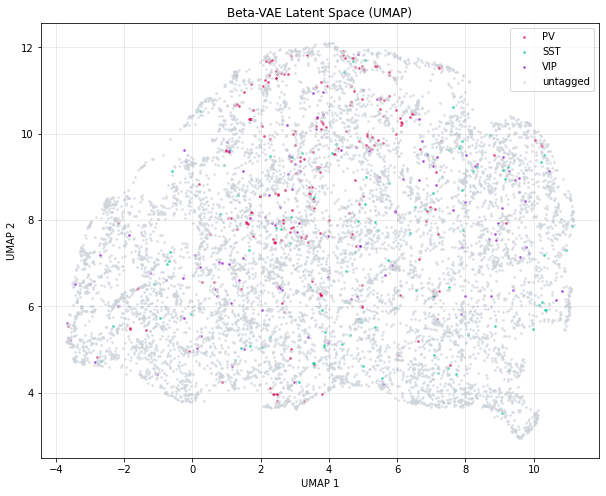

In [14]:
labels = ['PV', 'SST', 'VIP', 'untagged']
embeddings_2d_wf = visualize_latent_space(wf_vae, wf, labels, encoded_labels, min_dist=0.1,n_neighbors=20,savefig=True,filename='WF')
embeddings_2d_acg = visualize_latent_space(acg_vae, acg, labels, encoded_labels, min_dist=0.1,n_neighbors=20,savefig=True,filename='ACG')

In [15]:
def leaky_data_splitter(wf_vae,wf,acg_vae,acg,labels,train_size=0.9):
    
    tagged_ixs = [i for i, x in enumerate(labels['cell_type'].tolist()) if x != "untagged"]
    train_ixs, test_ixs = train_test_split(tagged_ixs,train_size=train_size)
    
    wf_embed = get_latent_embeddings(wf_vae, wf)
    wf_train_embed = wf_embed[train_ixs]
    wf_test_embed = wf_embed[test_ixs]
    
    acg_embed = get_latent_embeddings(acg_vae, acg)
    acg_train_embed = acg_embed[train_ixs]
    acg_test_embed = acg_embed[test_ixs]

    train_embed = [np.concatenate([vec1,vec2]) for vec1, vec2 in zip(wf_train_embed, acg_train_embed)]
    test_embed = [np.concatenate([vec1,vec2]) for vec1, vec2 in zip(wf_test_embed, acg_test_embed)]
    
    labels = uhd_labels.cell_type.to_numpy()[tagged_ixs]
    train_labels = labels[train_ixs]
    test_labels = labels[test_ixs]
    
    return train_embed, test_embed, train_labels, test_labels 

In [16]:
train, test, train_labels, test_labels = leaky_data_splitter(wf_vae,wf,acg_vae,acg,uhd_labels)

In [17]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(train)
X_test_scaled = scaler.transform(test)

# Initialize and train the MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,),  # One hidden layer with 100 units
                    activation='relu',           # ReLU activation function
                    solver='adam',               # Adam optimizer
                    max_iter=1000,              # Maximum iterations
                    random_state=42,            # For reproducibility
                    early_stopping=True,        # Enable early stopping
                    validation_fraction=0.1)    # Use 10% of training data for validation

# Train the model
mlp.fit(X_train_scaled, train_labels)

# Make predictions
train_predictions = mlp.predict(X_train_scaled)
test_predictions = mlp.predict(X_test_scaled)

# Print model performance
print("Training accuracy:", mlp.score(X_train_scaled, train_labels))
print("Test accuracy:", mlp.score(X_test_scaled, test_labels))

# Detailed classification report
print("\nClassification Report on Test Set:")
print(classification_report(test_labels, test_predictions))

# Print confusion matrix
print("\nConfusion Matrix on Test Set:")
print(confusion_matrix(test_labels, test_predictions))

# Learning curve information
print("\nNumber of iterations:", mlp.n_iter_)
print("Loss curve:", mlp.loss_curve_[-5:])  # Last 5 loss values

Training accuracy: 0.8575851393188855
Test accuracy: 0.7338129496402878

Classification Report on Test Set:
              precision    recall  f1-score   support

          PV       0.77      0.85      0.81        72
         SST       0.68      0.64      0.66        33
         VIP       0.69      0.59      0.63        34

    accuracy                           0.73       139
   macro avg       0.71      0.69      0.70       139
weighted avg       0.73      0.73      0.73       139


Confusion Matrix on Test Set:
[[61  6  5]
 [ 8 21  4]
 [10  4 20]]

Number of iterations: 28
Loss curve: [0.354317037448115, 0.34542187551611586, 0.33626599926736567, 0.32865151683717647, 0.3205481363950864]


In [18]:
confusion_matrix(test_labels, test_predictions)

array([[61,  6,  5],
       [ 8, 21,  4],
       [10,  4, 20]])

In [16]:
def plot_confusion_matrix(y_true, y_pred, class_names=None):
    """
    Create a confusion matrix visualization using seaborn's heatmap with percentages.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    class_names : list, optional
        List of class names for axis labels
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Convert to percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create figure and axes
    plt.figure(figsize=(10, 8))
    
    # If class names aren't provided, use unique labels
    if class_names is None:
        class_names = np.unique(y_true)
    
    # Create heatmap with percentages and fixed colorbar range
    sns.heatmap(cm_percentage, 
                annot=True,           # Show numbers in cells
                fmt='.1f',            # Use one decimal place
                cmap='viridis',       # Use viridis colormap
                square=True,          # Make cells square
                xticklabels=class_names,
                yticklabels=class_names,
                vmin=0,               # Minimum value for colorbar
                vmax=100,             # Maximum value for colorbar
                cbar_kws={'label': 'Percentage (%)'})
    
    # Add labels and title
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Percentages)')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt

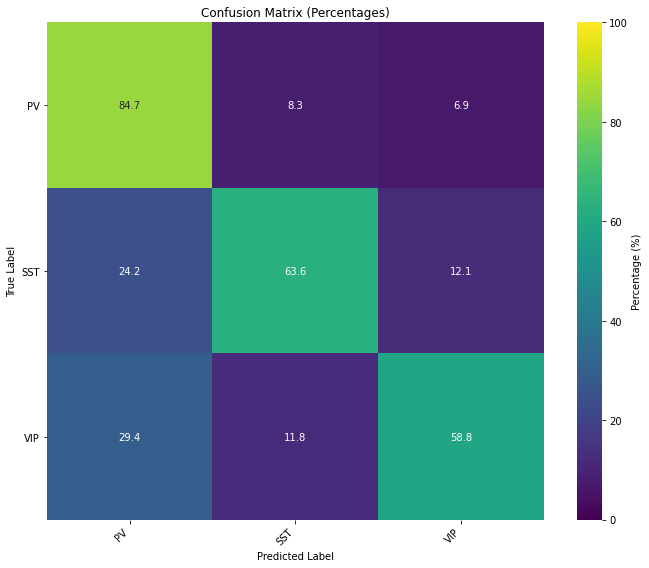

In [20]:
# Create the visualization using predictions from the MLP classifier
unique_labels = np.unique(test_labels)
plot_confusion_matrix(test_labels, test_predictions, class_names=unique_labels)
plt.show()

In [17]:
def leaky_simulation_loop(wf,acg,labels,loops=25,n_classes = 3):
    start = time.time()
    summed_conf_mat = np.zeros(shape=[n_classes,n_classes])
    conf_mat_list = []
    for i in tqdm(range(loops)):
        torch.cuda.manual_seed(i)
        random.seed(i)
        np.random.seed(i)
        
        wf_vae = WaveformVAE(input_dim=wf.shape[2], latent_dim=10)  # Match latent dim to Herzfeld, Hall, and Lisberger
        acg_vae = ACGVAE(latent_dim=10)  # Match latent dim to Herzfeld, Hall, and Lisberger

        # Train with KL annealing
        wf_vae, acg_vae, wf_losses, acg_losses = train_vaes(
            wf_vae, 
            acg_vae, 
            wf, 
            acg,
            epochs = 200, # (100)
            learning_rate=1e-4,  # Reduced learning rate (1e-3)
            max_wf_beta = 0.01, # Reduced beta to emphasize reconstruction (0.01)
            max_acg_beta = 0.01,
            warmup_epochs=0,
            steepness=0.01,
            plot_training=False
        )
        
        train, test, train_labels, test_labels = leaky_data_splitter(wf_vae,wf,acg_vae,acg,labels)
        
        # Fit the scaler on training data and transform both training and test data
        scaler = StandardScaler()
        train = scaler.fit_transform(train)
        test = scaler.transform(test)

        # Initialize and train the MLP
        mlp = MLPClassifier(hidden_layer_sizes=(100,),  # One hidden layer with 100 units
                            activation='relu',           # ReLU activation function
                            solver='adam',               # Adam optimizer
                            max_iter=1000,              # Maximum iterations
                            random_state=i,            # For reproducibility
                            early_stopping=True,        # Enable early stopping
                            validation_fraction=0.1)    # Use 10% of training data for validation

        # Train the model
        mlp.fit(train, train_labels)

        # Make predictions
        train_predictions = mlp.predict(train)
        test_predictions = mlp.predict(test)
        
        conf_mat = confusion_matrix(test_labels, test_predictions)
        
        print(np.round(conf_mat/sum(conf_mat),2))
        
        summed_conf_mat = summed_conf_mat + conf_mat
        conf_mat_list.append(conf_mat)
        
        end = time.time()
        print(end - start)
        
    return summed_conf_mat, conf_mat_list

In [18]:
def data_splitter(wf,acg,labels,train_size=0.9):
    
    ixs = range(len(labels))
    train_ixs, test_ixs = train_test_split(ixs,train_size=train_size)
    
    wf_train = wf[train_ixs]
    wf_test = wf[test_ixs]

    acg_train = acg[train_ixs]
    acg_test = acg[test_ixs]
    
    acg_train_dim = acg_train.shape
    acg_test_dim = acg_test.shape
#     acg_train = acg_train.reshape(acg_train_dim[0],acg_train_dim[1]*acg_train_dim[2])
#     acg_test = acg_test.reshape(acg_test_dim[0],acg_test_dim[1]*acg_test_dim[2])
    
    labels = labels.cell_type.to_numpy()
    train_labels = labels[train_ixs]
    test_labels = labels[test_ixs]
    
    return wf_train, wf_test, acg_train, acg_test, train_labels, test_labels 

def simulation_loop(wf,acg,labels,loops=25,n_classes = 3):
    start = time.time()
    summed_conf_mat = np.zeros(shape=[n_classes,n_classes])
    
    for i in tqdm(range(loops)):
        torch.cuda.manual_seed(i)
        random.seed(i)
        np.random.seed(i)
        
        wf_train, wf_test, acg_train, acg_test, train_labels, test_labels = data_splitter(wf,acg,labels)

        wf_vae = WaveformVAE(input_dim=wf.shape[2], latent_dim=10)  # Match latent dim to Herzfeld, Hall, and Lisberger
        acg_vae = ACGVAE(latent_dim=10)  # Match latent dim to Herzfeld, Hall, and Lisberger

        # Train with KL annealing
        wf_vae, acg_vae, wf_losses, acg_losses = train_vaes(
            wf_vae, 
            acg_vae, 
            wf_train, 
            acg_train,
            epochs = 200, # (100),
            learning_rate=1e-4,  # Reduced learning rate (1e-3)
            beta = 0.01 # Reduced beta to emphasize reconstruction (0.01)
        )
                                
        wf_train_embed = get_latent_embeddings(wf_vae, wf_train)
        acg_train_embed = get_latent_embeddings(acg_vae, acg_train)
                                
        wf_test_embed = get_latent_embeddings(wf_vae, wf_test)
        acg_test_embed = get_latent_embeddings(acg_vae, acg_test)
                                
        train = [np.concatenate([vec1,vec2]) for vec1, vec2 in zip(wf_train_embed, acg_train_embed)]
        test = [np.concatenate([vec1,vec2]) for vec1, vec2 in zip(wf_test_embed, acg_test_embed)]
        
        #Normalize the data
        scaler = StandardScaler()
        train = scaler.fit_transform(train)
        test = scaler.transform(test)

        # Initialize and train the MLP
        mlp = MLPClassifier(hidden_layer_sizes=(100,),  # One hidden layer with 100 units
                            activation='relu',           # ReLU activation function
                            solver='adam',               # Adam optimizer
                            max_iter=1000,              # Maximum iterations
                            random_state=i,            # For reproducibility
                            early_stopping=True,        # Enable early stopping
                            validation_fraction=0.1)    # Use 10% of training data for validation

            
        train_tagged_ixs = [i for i, x in enumerate(train_labels) if x != "untagged"]
        test_tagged_ixs = [i for i, x in enumerate(test_labels) if x != "untagged"]
        
        train_data = [train[i] for i in train_tagged_ixs]
        train_labels = [train_labels[i] for i in train_tagged_ixs]
        test_data = [test[i] for i in test_tagged_ixs]
        test_labels = [test_labels[i] for i in test_tagged_ixs]
        
        # Train the model
        mlp.fit(train_data, train_labels)

        # Make predictions
        train_predictions = mlp.predict(train_data)
        test_predictions = mlp.predict(test_data)
        
        conf_mat = confusion_matrix(test_labels, test_predictions)
        
        print(np.round(conf_mat/sum(conf_mat),2))
        
        summed_conf_mat = summed_conf_mat + conf_mat
        
        
        end = time.time()
        print(end - start)
        
    return summed_conf_mat

In [19]:
def cv_simulation_loop(wf, acg, labels, loops=25, n_classes=3, n_folds=5):
    start = time.time()
    summed_conf_mat = np.zeros(shape=[n_classes, n_classes])
    fold_conf_mat_list = []
    for i in tqdm(range(loops)):
        torch.cuda.manual_seed(i)
        random.seed(i)
        np.random.seed(i)
        
        # Create indices for cross-validation
        ixs = np.array(range(len(labels)))
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=i)
        
        # Initialize fold-specific confusion matrix
        fold_conf_mat = np.zeros(shape=[n_classes, n_classes])
        
        # Perform k-fold cross-validation
        for fold, (train_idx, test_idx) in enumerate(tqdm(kf.split(ixs),leave=False)):
            # Get the actual indices for this fold
            current_train_idx = ixs[train_idx.tolist()]
            current_test_idx = ixs[test_idx.tolist()]
            
            # Split data using the fold indices
            wf_train = wf[current_train_idx]
            wf_test = wf[current_test_idx]
            acg_train = acg[current_train_idx]
            acg_test = acg[current_test_idx]
            train_labels = [labels.cell_type.to_list()[i] for i in current_train_idx]
            test_labels = [labels.cell_type.to_list()[i] for i in current_test_idx]
            
            # Initialize and train VAEs
            wf_vae = WaveformVAE(input_dim=wf.shape[2], latent_dim=10)
            acg_vae = ACGVAE(latent_dim=10)
            
            # Train with KL annealing
            wf_vae, acg_vae, wf_losses, acg_losses = train_vaes(
                wf_vae, 
                acg_vae, 
                wf_train, 
                acg_train,
                epochs = 200, # (100)
                learning_rate=1e-4,  # Reduced learning rate (1e-3)
                max_wf_beta = 0.01, # Reduced beta to emphasize reconstruction (0.01)
                max_acg_beta = 0.01,
                warmup_epochs=0,
                steepness=0.01,
                plot_training=False
            )
            
            # Get embeddings
            wf_train_embed = get_latent_embeddings(wf_vae, wf_train)
            acg_train_embed = get_latent_embeddings(acg_vae, acg_train)
            wf_test_embed = get_latent_embeddings(wf_vae, wf_test)
            acg_test_embed = get_latent_embeddings(acg_vae, acg_test)
            
            # Combine embeddings
            train = [np.concatenate([vec1, vec2]) for vec1, vec2 in zip(wf_train_embed, acg_train_embed)]
            test = [np.concatenate([vec1, vec2]) for vec1, vec2 in zip(wf_test_embed, acg_test_embed)]
            
            #Normalize the data
            scaler = StandardScaler()
            train = scaler.fit_transform(train)
            test = scaler.transform(test)
            
            # Initialize and train the MLP
            mlp = MLPClassifier(
                hidden_layer_sizes=(100,),
                activation='relu',
                solver='adam',
                max_iter=1000,
                random_state=i,
                early_stopping=True,
                validation_fraction=0.1
            )
            
            train_tagged_ixs = [i for i,x in enumerate(train_labels) if x != "untagged"]
            train = [x for i,x in enumerate(train) if i in train_tagged_ixs]
            train_labels = [x for x in train_labels if x != "untagged"]
            
            test_tagged_ixs = [i for i,x in enumerate(test_labels) if x != "untagged"]
            test = [x for i,x in enumerate(test) if i in test_tagged_ixs]
            test_labels = [x for x in test_labels if x != "untagged"]
        
            # Train the model
            mlp.fit(train, train_labels)
            
            # Make predictions
            test_predictions = mlp.predict(test)
            
            # Calculate confusion matrix for this fold
            fold_conf_mat += confusion_matrix(test_labels, test_predictions)
            
        # Average the confusion matrix across folds
        fold_conf_mat = fold_conf_mat / n_folds
        
        # Print normalized confusion matrix for this iteration
        print(f"Iteration {i+1} confusion matrix:")
        print(np.round(fold_conf_mat/np.sum(fold_conf_mat), 2))
        
        # Add to the summed confusion matrix
        summed_conf_mat += fold_conf_mat
        fold_conf_mat_list.append(fold_conf_mat)
        
        end = time.time()
        print(f"Time elapsed: {end - start:.2f} seconds")
    
    return summed_conf_mat,fold_conf_mat_list

In [ ]:
summed_conf_mat_leaky,fold_conf_mat_list = leaky_simulation_loop(wf, acg, uhd_labels, loops = 25, n_classes = 3)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/200], KL weight: 0.0000, WF Beta: 0.004988, ACG Beta: 0.004988
Waveform VAE - Total: 4840.6999, Recon: 4840.6999, KL: 634.5285
ACG VAE - Total: 2301.9771, Recon: 2301.9771, KL: 362.7478
Epoch [10/200], KL weight: 0.0450, WF Beta: 0.004989, ACG Beta: 0.004989
Waveform VAE - Total: 8.6531, Recon: 7.8843, KL: 3424.2129
ACG VAE - Total: 31.2093, Recon: 30.4664, KL: 3308.9060
Epoch [20/200], KL weight: 0.0950, WF Beta: 0.004990, ACG Beta: 0.004990
Waveform VAE - Total: 4.9615, Recon: 3.4751, KL: 3135.1294
ACG VAE - Total: 28.8587, Recon: 27.4243, KL: 3025.6077
Epoch [30/200], KL weight: 0.1450, WF Beta: 0.004992, ACG Beta: 0.004992
Waveform VAE - Total: 4.1161, Recon: 1.9755, KL: 2957.3998
ACG VAE - Total: 24.8832, Recon: 22.7936, KL: 2886.9450
Epoch [40/200], KL weight: 0.1950, WF Beta: 0.004993, ACG Beta: 0.004993
Waveform VAE - Total: 4.2834, Recon: 1.5560, KL: 2801.3597
ACG VAE - Total: 21.7836, Recon: 19.0334, KL: 2824.7628
Epoch [50/200], KL weight: 0.2450, WF Beta: 0.004994,

  4%|▍         | 1/25 [01:19<31:44, 79.34s/it]

Epoch [200/200], KL weight: 0.9950, WF Beta: 0.005013, ACG Beta: 0.005013
Waveform VAE - Total: 5.4062, Recon: 1.6452, KL: 754.0364
ACG VAE - Total: 17.8280, Recon: 14.3225, KL: 702.8282
[[0.85 0.11 0.09]
 [0.07 0.67 0.18]
 [0.07 0.22 0.73]]
79.33987259864807
Epoch [1/200], KL weight: 0.0000, WF Beta: 0.004988, ACG Beta: 0.004988
Waveform VAE - Total: 807.0388, Recon: 807.0388, KL: 660.3202
ACG VAE - Total: 1996.6156, Recon: 1996.6156, KL: 361.7642
Epoch [10/200], KL weight: 0.0450, WF Beta: 0.004989, ACG Beta: 0.004989
Waveform VAE - Total: 4.1843, Recon: 3.4650, KL: 3203.8173
ACG VAE - Total: 30.7671, Recon: 30.0305, KL: 3280.6499
Epoch [20/200], KL weight: 0.0950, WF Beta: 0.004990, ACG Beta: 0.004990
Waveform VAE - Total: 3.0021, Recon: 1.6123, KL: 2931.5997
ACG VAE - Total: 28.6902, Recon: 27.2659, KL: 3004.3074
Epoch [30/200], KL weight: 0.1450, WF Beta: 0.004992, ACG Beta: 0.004992
Waveform VAE - Total: 3.0962, Recon: 1.0966, KL: 2762.7396
ACG VAE - Total: 24.3018, Recon: 22.215

  8%|▊         | 2/25 [02:38<30:21, 79.18s/it]

Epoch [200/200], KL weight: 0.9950, WF Beta: 0.005013, ACG Beta: 0.005013
Waveform VAE - Total: 5.0754, Recon: 1.5670, KL: 703.3866
ACG VAE - Total: 17.7739, Recon: 14.3544, KL: 685.5647
[[0.81 0.29 0.14]
 [0.08 0.43 0.14]
 [0.12 0.29 0.71]]
158.14640831947327
Epoch [1/200], KL weight: 0.0000, WF Beta: 0.004988, ACG Beta: 0.004988
Waveform VAE - Total: 1033.2163, Recon: 1033.2163, KL: 672.1143
ACG VAE - Total: 3353.3893, Recon: 3353.3893, KL: 370.1935
Epoch [10/200], KL weight: 0.0450, WF Beta: 0.004989, ACG Beta: 0.004989
Waveform VAE - Total: 4.2446, Recon: 3.5174, KL: 3239.1404
ACG VAE - Total: 32.5244, Recon: 31.8102, KL: 3180.9626
Epoch [20/200], KL weight: 0.0950, WF Beta: 0.004990, ACG Beta: 0.004990
Waveform VAE - Total: 3.2778, Recon: 1.8666, KL: 2976.6935
ACG VAE - Total: 29.7414, Recon: 28.3063, KL: 3027.0461
Epoch [30/200], KL weight: 0.1450, WF Beta: 0.004992, ACG Beta: 0.004992
Waveform VAE - Total: 3.2635, Recon: 1.2306, KL: 2808.6905
ACG VAE - Total: 26.3907, Recon: 24.

 12%|█▏        | 3/25 [03:56<28:59, 79.08s/it]

Epoch [200/200], KL weight: 0.9950, WF Beta: 0.005013, ACG Beta: 0.005013
Waveform VAE - Total: 5.1312, Recon: 1.5651, KL: 714.9639
ACG VAE - Total: 18.0505, Recon: 14.4019, KL: 731.5113
[[0.86 0.   0.1 ]
 [0.03 0.88 0.2 ]
 [0.1  0.12 0.7 ]]
236.97878575325012
Epoch [1/200], KL weight: 0.0000, WF Beta: 0.004988, ACG Beta: 0.004988
Waveform VAE - Total: 995.6306, Recon: 995.6306, KL: 488.5038
ACG VAE - Total: 3590.4322, Recon: 3590.4322, KL: 411.7866
Epoch [10/200], KL weight: 0.0450, WF Beta: 0.004989, ACG Beta: 0.004989
Waveform VAE - Total: 4.0768, Recon: 3.3833, KL: 3088.7625
ACG VAE - Total: 37.9165, Recon: 37.1854, KL: 3256.3973
Epoch [20/200], KL weight: 0.0950, WF Beta: 0.004990, ACG Beta: 0.004990
Waveform VAE - Total: 3.1337, Recon: 1.7931, KL: 2827.9176
ACG VAE - Total: 31.4211, Recon: 30.0180, KL: 2959.5755
Epoch [30/200], KL weight: 0.1450, WF Beta: 0.004992, ACG Beta: 0.004992
Waveform VAE - Total: 3.1694, Recon: 1.2406, KL: 2664.8804
ACG VAE - Total: 28.4684, Recon: 26.42

 28%|██▊       | 7/25 [09:08<23:24, 78.02s/it]

Epoch [200/200], KL weight: 0.9950, WF Beta: 0.005013, ACG Beta: 0.005013
Waveform VAE - Total: 4.7405, Recon: 1.5383, KL: 641.9993
ACG VAE - Total: 17.9872, Recon: 14.3938, KL: 720.4451
[[0.9  0.08 0.14]
 [0.05 0.69 0.07]
 [0.05 0.23 0.79]]
548.5329747200012
Epoch [1/200], KL weight: 0.0000, WF Beta: 0.004988, ACG Beta: 0.004988
Waveform VAE - Total: 830.2787, Recon: 830.2787, KL: 614.1779
ACG VAE - Total: 2975.3285, Recon: 2975.3285, KL: 394.6240
Epoch [10/200], KL weight: 0.0450, WF Beta: 0.004989, ACG Beta: 0.004989
Waveform VAE - Total: 4.3115, Recon: 3.6106, KL: 3121.9268
ACG VAE - Total: 31.7741, Recon: 31.0313, KL: 3308.7346
Epoch [20/200], KL weight: 0.0950, WF Beta: 0.004990, ACG Beta: 0.004990
Waveform VAE - Total: 3.0361, Recon: 1.6777, KL: 2865.2485
ACG VAE - Total: 29.1606, Recon: 27.7229, KL: 3032.5088
Epoch [30/200], KL weight: 0.1450, WF Beta: 0.004992, ACG Beta: 0.004992
Waveform VAE - Total: 3.1003, Recon: 1.1534, KL: 2689.9090
ACG VAE - Total: 25.7092, Recon: 23.612

 32%|███▏      | 8/25 [10:25<22:01, 77.74s/it]

Epoch [200/200], KL weight: 0.9950, WF Beta: 0.005013, ACG Beta: 0.005013
Waveform VAE - Total: 4.9608, Recon: 1.6027, KL: 673.2754
ACG VAE - Total: 17.8924, Recon: 14.3675, KL: 706.7085
[[0.77 0.29 0.  ]
 [0.1  0.57 0.3 ]
 [0.13 0.14 0.7 ]]
625.6157383918762
Epoch [1/200], KL weight: 0.0000, WF Beta: 0.004988, ACG Beta: 0.004988
Waveform VAE - Total: 1152.9366, Recon: 1152.9366, KL: 694.9609
ACG VAE - Total: 1965.4973, Recon: 1965.4973, KL: 379.1107
Epoch [10/200], KL weight: 0.0450, WF Beta: 0.004989, ACG Beta: 0.004989
Waveform VAE - Total: 4.6729, Recon: 3.9465, KL: 3235.8354
ACG VAE - Total: 30.8121, Recon: 30.0726, KL: 3293.8979
Epoch [20/200], KL weight: 0.0950, WF Beta: 0.004990, ACG Beta: 0.004990
Waveform VAE - Total: 3.4943, Recon: 2.0985, KL: 2944.2470
ACG VAE - Total: 27.9516, Recon: 26.5224, KL: 3014.8189
Epoch [30/200], KL weight: 0.1450, WF Beta: 0.004992, ACG Beta: 0.004992
Waveform VAE - Total: 3.4138, Recon: 1.4218, KL: 2752.2150
ACG VAE - Total: 23.4002, Recon: 21.2

In [5]:
summed_conf_mat_leaky/sum(summed_conf_mat_leaky)

NameError: name 'summed_conf_mat_leaky' is not defined

In [ ]:
with open("summed_conf_mat_leaky.pkl", "wb") as file:
    pickle.dump(summed_conf_mat_leaky, file) 

In [ ]:
with open("fold_conf_mat_list.pkl", "wb") as file:
    pickle.dump(fold_conf_mat_list, file) 

In [6]:
with open("fold_conf_mat_list.pkl", 'rb') as file:
        data = pickle.load(file)

In [7]:
data

[array([[23,  1,  1],
        [ 2,  6,  2],
        [ 2,  2,  8]]),
 array([[21,  2,  2],
        [ 2,  3,  2],
        [ 3,  2, 10]]),
 array([[25,  0,  1],
        [ 1,  7,  2],
        [ 3,  1,  7]]),
 array([[17,  2,  1],
        [ 4,  9,  1],
        [ 3,  2,  8]]),
 array([[19,  5,  0],
        [ 2,  9,  1],
        [ 2,  2,  7]]),
 array([[22,  1,  3],
        [ 5,  2,  4],
        [ 5,  2,  3]]),
 array([[18,  1,  2],
        [ 1,  9,  1],
        [ 1,  3, 11]]),
 array([[23,  2,  0],
        [ 3,  4,  3],
        [ 4,  1,  7]]),
 array([[19,  0,  0],
        [ 1,  7,  2],
        [ 5,  5,  8]]),
 array([[20,  2,  1],
        [ 0,  7,  3],
        [ 3,  4,  7]]),
 array([[19,  1,  1],
        [ 2,  8,  1],
        [ 2,  4,  9]]),
 array([[17,  2,  7],
        [ 2,  5,  5],
        [ 4,  1,  4]]),
 array([[21,  2,  1],
        [ 0,  5,  2],
        [ 2,  2, 12]]),
 array([[21,  1,  1],
        [ 5,  6,  1],
        [ 5,  0,  7]]),
 array([[21,  2,  1],
        [ 4,  7,  0],
    

In [ ]:
summed_conf_mat = cv_simulation_loop(wf, acg, uhd_labels, loops = 25, n_classes = 3)

In [ ]:
summed_conf_mat/sum(summed_conf_mat)

In [ ]:
with open("summed_conf_mat.pkl", "wb") as file:
    pickle.dump(summed_conf_mat_noleak, file) 

In [ ]:
summed_conf_mat_leaky_noscaler = leaky_simulation_loop(wf,acg,uhd_labels,loops=25,n_classes = 3)

In [ ]:
with open("summed_conf_mat_leaky_noscaler.pkl", "wb") as file:
    pickle.dump(summed_conf_mat_leaky_noscaler, file) 

In [ ]:
summed_conf_mat = np.array([
  [0.7484, 0.1604, 0.1124],
  [0.1176, 0.6372, 0.1960],
  [0.1328, 0.2024, 0.6892]
])

In [ ]:
# with open(r"summed_conf_mat_noleak.pkl", "rb") as input_file:
#     e = pickle.load(input_file)